# Calculate climatology and anomaly of ERA5 net shortwave and sst

In [20]:
import xarray as xr
import matplotlib.pyplot as plt
import json
import gcsfs
from scipy.signal import detrend

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/sw_sst.zarr'))

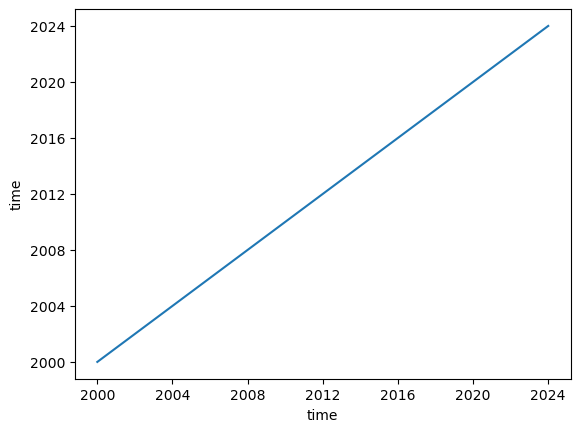

In [26]:
ds.time.plot()

In [27]:
ds0012 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/sw_sst_0012.zarr'))
ds1322 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/sw_sst_1322.zarr'))
ds23 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/sw_sst23.zarr'))
ds = xr.concat([ds0012, ds1322, ds23], dim='time')
#ds23 = xr.open_dataset('sw_sst_2023.nc')

In [15]:
ds_whole = xr.concat([ds0012, ds1322, ds23], dim='time')

In [17]:
ds_whole

<xarray.Dataset>
Dimensions:    (latitude: 37, longitude: 113, time: 210384)
Coordinates:
  * latitude   (latitude) float32 31.0 30.75 30.5 30.25 ... 22.5 22.25 22.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -72.5 -72.25 -72.0
  * time       (time) datetime64[ns] 2000-01-01 ... 2023-12-31T23:00:00
Data variables:
    ssr        (time, latitude, longitude) float32 dask.array<chunksize=(8784, 37, 113), meta=np.ndarray>
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(8784, 37, 113), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-03-27 18:58:51 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [19]:
#uploading era sw/sst ds from 2000 - 2023
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)


gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/sw_sst.zarr')
ds_whole.to_zarr(gcsmap_ds, mode='w', safe_chunks=False)

## Shortwave

In [28]:
#convert sw from J/m^2 -> W/m^2
sw_wm2 = ds.ssr / (60*60)
#resample to daily freq (hourly too noisy
sw = sw_wm2.resample(time='D').mean('time')

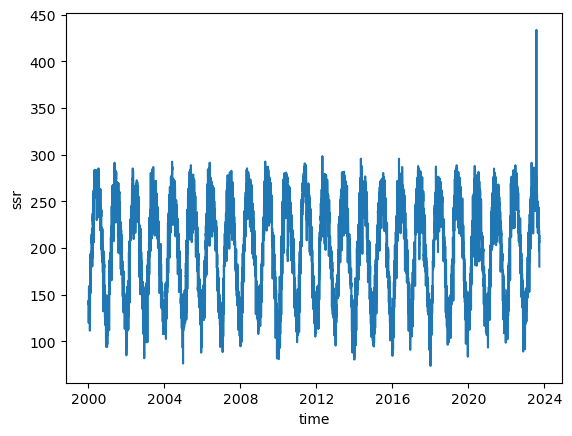

In [29]:
sw.mean(['latitude', 'longitude']).plot();

In [30]:
mo_clim_sw = (sw).groupby('time.month').mean(['time', 'latitude', 'longitude'])
mo_anom_sw = (sw).groupby('time.month') - mo_clim_sw

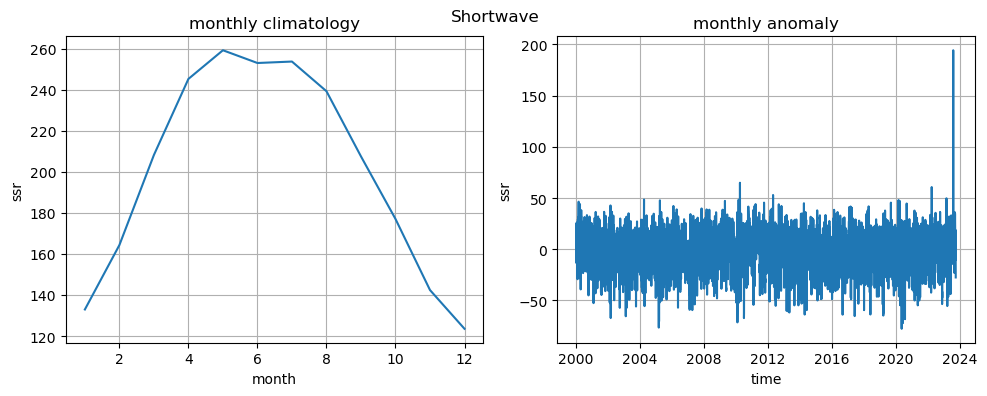

In [31]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

mo_clim_sw.plot(ax=ax0)
ax0.set_title('monthly climatology')
ax0.grid()
mo_anom_sw.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('monthly anomaly')
ax1.grid()
plt.tight_layout()
plt.suptitle('Shortwave');

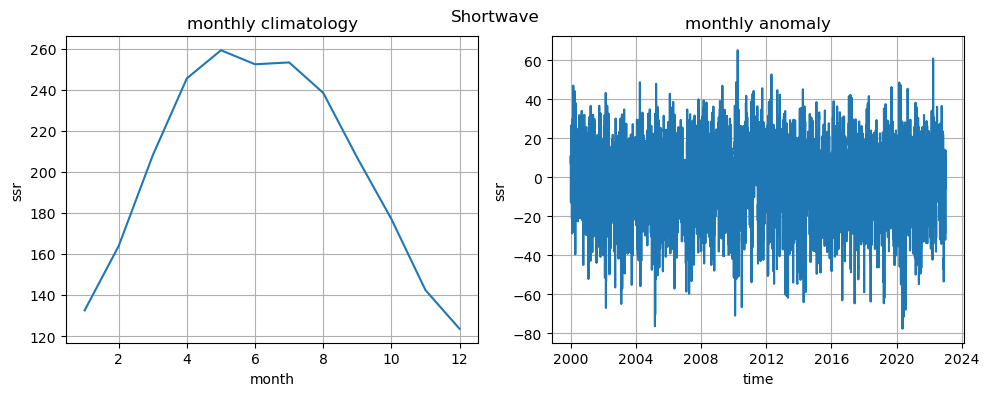

In [31]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

mo_clim_sw.plot(ax=ax0)
ax0.set_title('monthly climatology')
ax0.grid()
mo_anom_sw.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('monthly anomaly')
ax1.grid()
plt.tight_layout()
plt.suptitle('Shortwave');

In [28]:
yr_clim_sw = (sw).groupby('time.year').mean(['time', 'latitude', 'longitude'])
yr_anom_sw = (sw).groupby('time.year') - yr_clim_sw

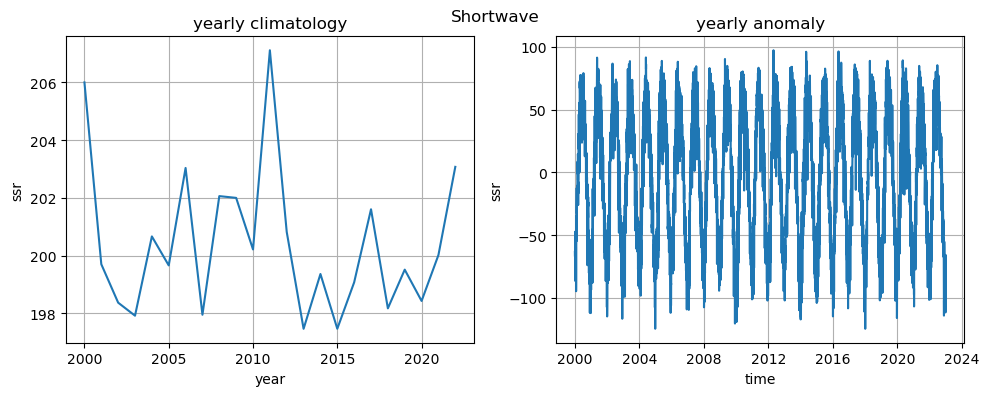

In [32]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

yr_clim_sw.plot(ax=ax0)
ax0.set_title('yearly climatology')
ax0.grid()
yr_anom_sw.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('yearly anomaly')
ax1.grid()
plt.tight_layout()
plt.suptitle('Shortwave');

## SST

In [33]:
#convert to ˚C and resample to daily freq (hourly too noisy)
sst = (ds.sst-273.15).resample(time='D').mean('time')

In [34]:
mo_clim_sst = sst.groupby('time.month').mean(['time', 'latitude', 'longitude'])
mo_anom_sst = sst.groupby('time.month') - mo_clim_sst

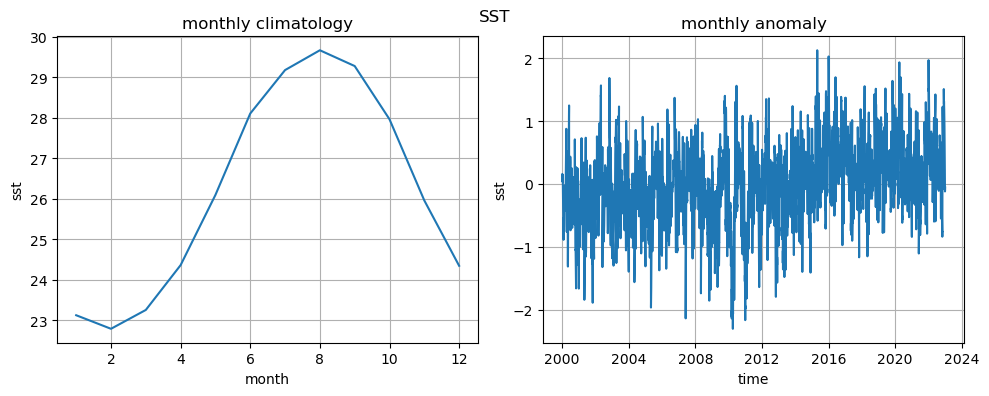

In [36]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

mo_clim_sst.plot(ax=ax0)
ax0.set_title('monthly climatology')
ax0.grid()
mo_anom_sst.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('monthly anomaly')
ax1.grid()
plt.tight_layout()
plt.suptitle('SST');

In [103]:
#-75˚W, 28.5˚N
detrend(sst[:, 10, 100].fillna(0.), type='linear')

array([-1.6067867, -1.5641251, -1.556406 , ..., -2.146267 , -2.3005295,
       -2.1872005], dtype=float32)

In [104]:
sst_detrended = detrend(sst[:,10,100], type='linear')
sst_d = xr.DataArray(data=sst_detrended, coords={'time':sst.time})

In [105]:
sst_d

<xarray.DataArray (time: 8401)>
array([-1.6067867, -1.5641251, -1.556406 , ..., -2.146267 , -2.3005295,
       -2.1872005], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2022-12-31

In [106]:
mo_clim_sst_d = sst_d.groupby('time.month').mean(['time'])
mo_anom_sst_d = sst_d.groupby('time.month') - mo_clim_sst_d

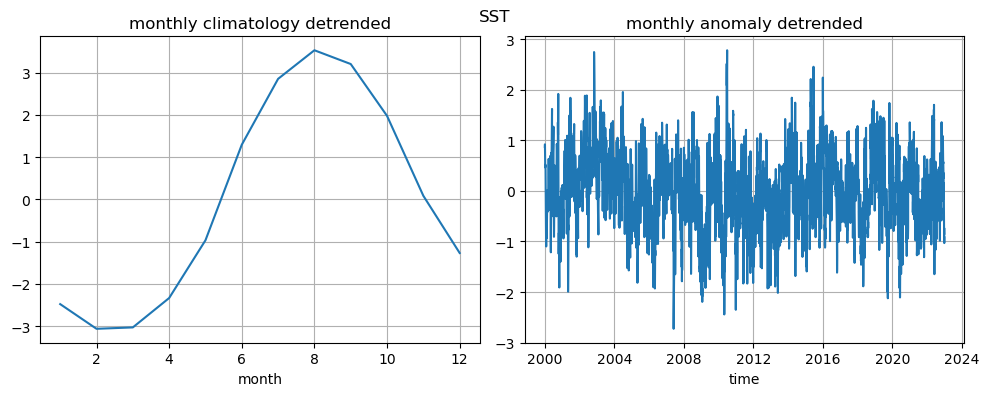

In [107]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

mo_clim_sst_d.plot(ax=ax0)
ax0.set_title('monthly climatology detrended')
ax0.grid()
mo_anom_sst_d.plot(ax=ax1)
ax1.set_title('monthly anomaly detrended')
ax1.grid()
plt.tight_layout()
plt.suptitle('SST');

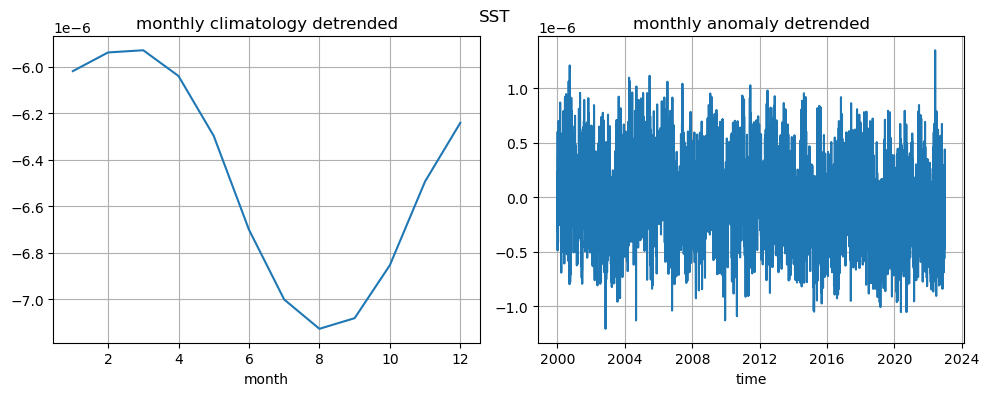

In [94]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

mo_clim_sst_d.plot(ax=ax0)
ax0.set_title('monthly climatology detrended')
ax0.grid()
mo_anom_sst_d.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('monthly anomaly detrended')
ax1.grid()
plt.tight_layout()
plt.suptitle('SST');

In [37]:
yr_clim_sst = sst.groupby('time.year').mean(['time', 'latitude', 'longitude'])
yr_anom_sst = sst.groupby('time.year') - yr_clim_sst

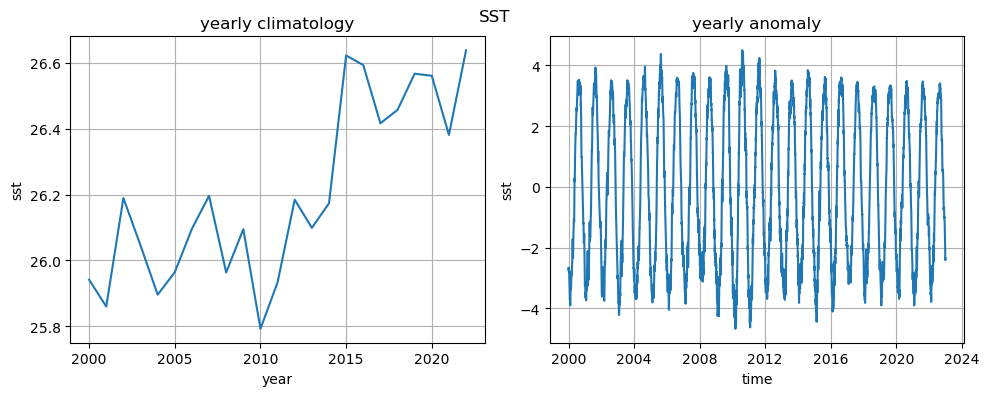

In [39]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

yr_clim_sst.plot(ax=ax0)
ax0.set_title('yearly climatology')
ax0.grid()
yr_anom_sst.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('yearly anomaly')
ax1.grid()
plt.tight_layout()
plt.suptitle('SST');